In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import autograd.numpy as np
from autograd import grad
from autograd.core import primitive
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
from scipy.misc import imread, imresize, imsave
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as spla
import os
import sys
import cv2
import caffe

# Model

In [4]:
# set up
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
net = caffe.Net('models/hough_v6.deploy', 'models/hough_v6.caffemodel', caffe.TEST)

# Raw

In [5]:
img = imread('data/misc/pos.png', mode='RGB')
# img = imread('data/misc/fp.png', mode='RGB')
img_small = imresize(img, [80, 80])
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()
pred_small = imresize(pred, [80, 80]) / 255

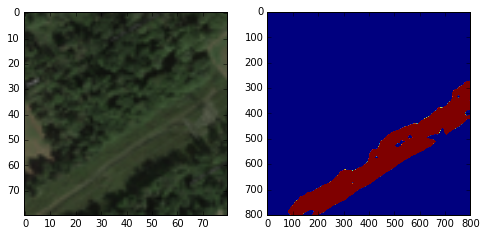

In [6]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img_small)
plt.subplot(122)
plt.imshow(pred)

# Draw straight

In [7]:
sin = lambda x: np.sin(x*np.pi/180)
cos = lambda x: np.cos(x*np.pi/180)

def draw_straight(img, angle=30, width=10, gap=120,
                  xoff=0, yoff=0, alpha=.2):
    H, W, _ = img.shape
    assert H == W == 800
    R = H
    x1 = xoff + W/2 - R*cos(angle)
    y1 = yoff + H/2 - R*sin(angle)
    x2 = xoff + W/2 + R*cos(angle)
    y2 = yoff + H/2 + R*sin(angle)
    
    img_ln = np.zeros_like(img)
    cv2.line(img_ln,
             (int(x1), int(y1)),
             (int(x2), int(y2)),
             (255, 255, 255), width)
    cv2.line(img_ln,
             (int(x1-gap*sin(angle)), int(y1-gap*cos(angle))),
             (int(x2-gap*sin(angle)), int(y2-gap*cos(angle))),
             (255, 255, 255), width)
    cv2.line(img_ln,
             (int(x1+gap*sin(angle)), int(y1+gap*cos(angle))),
             (int(x2+gap*sin(angle)), int(y2+gap*cos(angle))),
             (255, 255, 255), width)
    syn = cv2.addWeighted(img, 1, img_ln, alpha, 0.)
    return syn

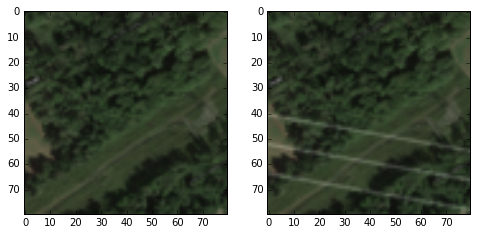

In [37]:
syn = draw_straight(img, angle=10, gap=120, xoff=20, yoff=200)
syn_small = imresize(syn, [80, 80])
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img_small)
plt.subplot(122)
plt.imshow(syn_small)

In [9]:
in_ = np.array(syn, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()
pred_small = imresize(pred, [80, 80]) / 255

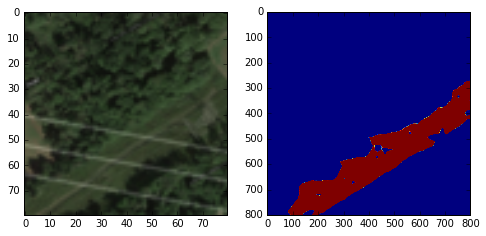

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(syn_small)
plt.subplot(122)
plt.imshow(pred)

# Draw broken

In [11]:
def draw_broken(img, angle=30, delta_angle=20, width=10, gap=120,
                xoff=0, yoff=0, alpha=.2):
    H, W, _ = img.shape
    assert H == W == 800
    R = H
    xoff += W/2
    yoff += H/2
    x1 = xoff - R*cos(angle)
    y1 = yoff - R*sin(angle)
    x2 = xoff + R*cos(angle+delta_angle)
    y2 = yoff + R*sin(angle+delta_angle)
    
    img_ln = np.zeros_like(img)
    cv2.line(img_ln,
             (int(xoff-gap*cos(90+angle)), int(yoff-gap*sin(90+angle))),
             (int(xoff+gap*cos(90+angle)), int(yoff+gap*sin(90+angle))),
             (255, 255, 255), width)
    
    cv2.line(img_ln,
             (int(x1), int(y1)),
             (int(xoff), int(yoff)),
             (255, 255, 255), width)
    cv2.line(img_ln,
             (int(xoff), int(yoff)),
             (int(x2), int(y2)),
             (255, 255, 255), width)
    
    cv2.line(img_ln,
             (int(x1-gap*cos(90+angle)), int(y1-gap*sin(90+angle))),
             (int(xoff-gap*cos(90+angle)), int(yoff-gap*sin(90+angle))),
             (255, 255, 255), width)
    cv2.line(img_ln,
             (int(xoff-gap*cos(90+angle)), int(yoff-gap*sin(90+angle))),
             (int(x2-gap*cos(90+angle)), int(y2-gap*sin(90+angle))),
             (255, 255, 255), width)
    
    cv2.line(img_ln,
             (int(x1+gap*cos(90+angle)), int(y1+gap*sin(90+angle))),
             (int(xoff+gap*cos(90+angle)), int(yoff+gap*sin(90+angle))),
             (255, 255, 255), width)
    cv2.line(img_ln,
             (int(xoff+gap*cos(90+angle)), int(yoff+gap*sin(90+angle))),
             (int(x2+gap*cos(90+angle)), int(y2+gap*sin(90+angle))),
             (255, 255, 255), width)
    
    syn = cv2.addWeighted(img, 1, img_ln, alpha, 0.)
    return syn

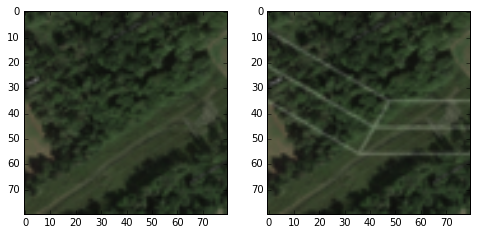

In [12]:
syn = draw_broken(img, angle=30, delta_angle=-30, xoff=20, yoff=60, alpha=.2)
syn_small = imresize(syn, [80, 80])
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img_small)
plt.subplot(122)
plt.imshow(syn_small)

# Draw composite

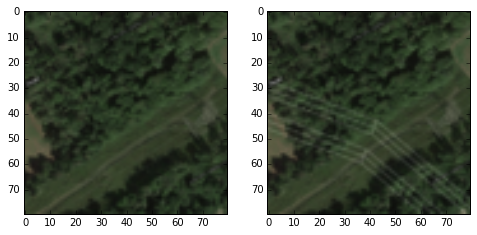

In [46]:
angle = 20
dist = 120
gap = 28
width = 4
syn = draw_broken(img, angle=angle, gap=gap, xoff=20, yoff=60,
                    width=width, alpha=.2)
syn = draw_broken(syn, angle=angle, gap=gap,
                    xoff=20+dist*cos(angle+90), yoff=60+dist*sin(angle+90),
                    width=width, alpha=.2)
syn_small = imresize(syn, [80, 80])
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img_small)
plt.subplot(122)
plt.imshow(syn_small)